In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from tensorboardX import SummaryWriter
import torchvision.utils as vutils

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 40
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=24
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data

In [5]:
list_of_frequents = np.array([600, 450, 300, 150, 100])
list_of_A = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 1.25])


def align(k, window = 5):
    k = np.asarray(k)
    length = k.shape[0]
    for i in range(0, length, window):
        k[i:i + window] = k[i:i + window]*0 + k[i]
    
    
    return k

def GeneratorOfTimeSeries(n = 60, m = 128):
    X = np.ones([m, n])*np.linspace(start = 0, stop = 0.1, num = n)
    T1 = []
    T2 = []
    for x in X:
#         ind = np.random.randint(0, len(list_of_frequents), size = n)
#         k = align(list_of_frequents[ind], 15)
#         A = align(list_of_A[ind], 15)
#         T1.append(A*np.sin(k*x))
#         T2.append(A*np.sin(k*x))
        ARR = np.random.randn(n)
        T1.append(ARR)
        T2.append(ARR)
        
    T1 = np.asarray(T1)
    T2 = np.asarray(T2)
    return X, np.reshape(T1, [T1.shape[0], T1.shape[1], 1]), np.reshape(T2, [T2.shape[0], T2.shape[1], 1])


In [6]:
step, X_train, Y_train = GeneratorOfTimeSeries()
step, X_test, Y_test = GeneratorOfTimeSeries()

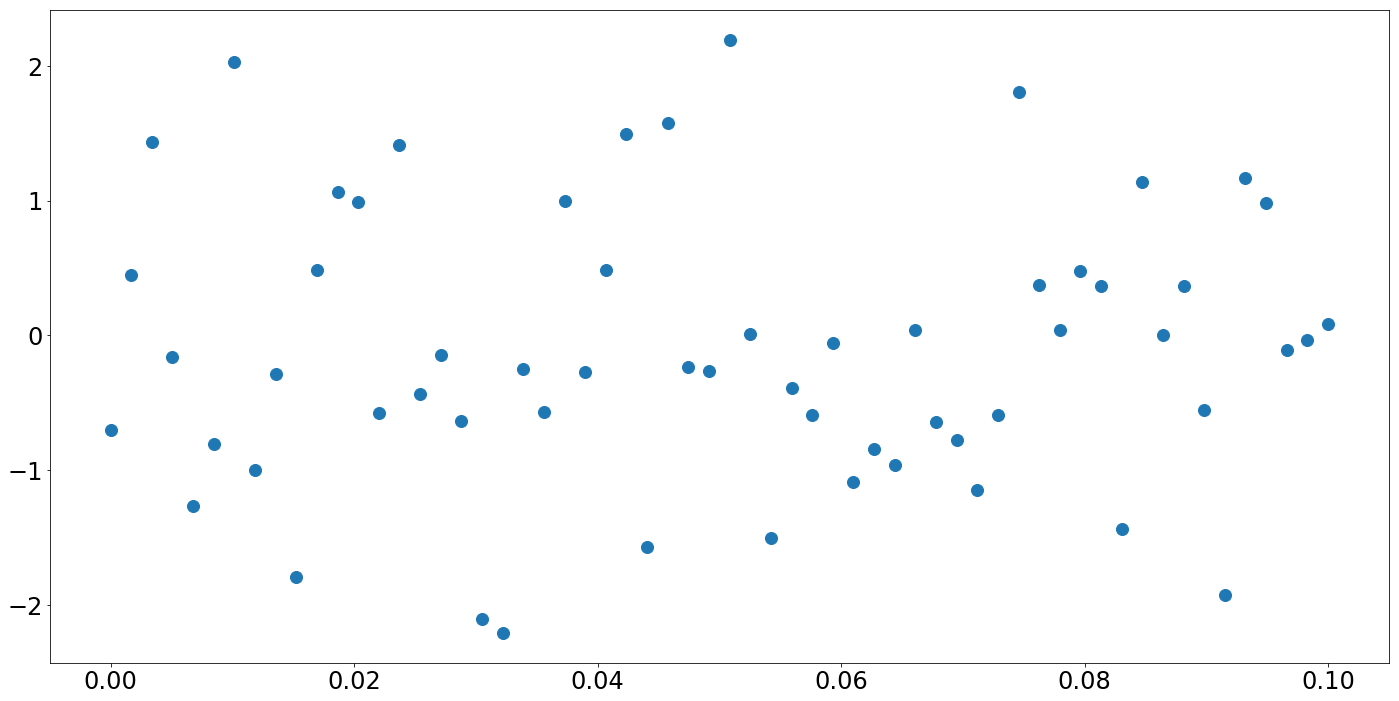

In [7]:
plt.plot(step[0], X_train[0], 'o')

# Generator

In [8]:
def batches_generator(batch_size, input, output, shuffle=True, allow_smaller_last_batch=True, device = 'cpu'):
    n_samples = len(input)
    
    list_of_indexes = np.linspace(0, len(input) - 1, len(input), dtype=np.int64)
    list_of_x = []
    list_of_y = []
    
    if shuffle:
        np.random.shuffle(list_of_indexes)
        
    for indx in list_of_indexes:
        list_of_x.append(input[indx])
        list_of_y.append(output[indx])
    
    n_batches = n_samples//batch_size

    if n_samples%batch_size != 0:
        n_batches+=1
        
    for k in range(n_batches):
        this_batch_size = batch_size
        
        if k == n_batches - 1:
            if n_samples%batch_size > 0:
                this_batch_size = n_samples%batch_size
            if allow_smaller_last_batch is False:
                if this_batch_size < batch_size:
                    break

        length_of_sentence_x = 0
        length_of_sentence_y = 0
        for t in range(k*batch_size, k*batch_size + this_batch_size):
            if len(list_of_x[t]) > length_of_sentence_x:
                length_of_sentence_x = len(list_of_x[t])
            if len(list_of_y[t]) > length_of_sentence_y:
                length_of_sentence_y = len(list_of_y[t])
        
        x_arr = np.ones(shape=[this_batch_size, length_of_sentence_x, 1])*0
        y_arr = np.ones(shape=[this_batch_size, length_of_sentence_y, 1])*0
        
        for i in range(this_batch_size):
            for j, (x, y) in enumerate(zip(list_of_x[k*batch_size + i], list_of_y[k*batch_size + i])):
                x_arr[i, j, 0] = x
                y_arr[i, j, 0] = y
                
            
        x_tr = torch.FloatTensor(x_arr)
        y_tr = torch.FloatTensor(y_arr)
        
        x_tr = x_tr.float().to(device)
        y_tr = y_tr.float().to(device)
        yield x_tr, y_tr
    return

# Define Attention

In [9]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()

    def get_scores(self, e, h):
        """
        features: [batch_size x num_objects x obj_feature_dim]
        queries:  [batch_size x num_queries x query_feature_dim]
        Returns matrix of scores with shape [batch_size x num_queries x num_objects].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        raise NotImplementedError()                

    def forward(self, e, h):
        """
        features:        [batch_size x num_objects x obj_feature_dim]
        queries:         [batch_size x num_queries x query_feature_dim]
        Returns matrix of features for queries with shape [batch_size x num_queries x obj_feature_dim].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]     
        
        result has a shape [batch_size, time_len_in_h, dim_e]
        alpha has a shape [batch_size, time_len_in_h, time_len_in_e]
        
        """
        scores = self.get_scores(e, h)
        alphas = F.softmax(scores, 2)
        result = torch.bmm(alphas, e)
        return result, torch.tensor(alphas.detach())
    
class AdditiveAttention(Attention):
    def __init__(self, dim_e, dim_h, hidden_dim):
        """
        obj_feature_dim   - dimensionality of attention object features vector
        query_feature_dim - dimensionality of attention query vector
        hidden_dim        - dimensionality of latent vectors of attention
        
        dim_e      - hidden dimension of encoder
        
        dim_h      - hidden dimension of decoder
    
        hidden_dim        - hidden dimension of attention
        
        
        """
        super(AdditiveAttention, self).__init__()
        
        self.dim_e = dim_e
        self.dim_h = dim_h
        self.hidden_dim = hidden_dim
        
        self.W1 = nn.Linear(dim_e, hidden_dim, bias=False)
        self.W2 = nn.Linear(dim_h, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, 1, bias=False)

    def get_scores(self, e, h):
        """
        features: [batch_size x num_objects x obj_feature_dim]
        queries:  [batch_size x num_queries x query_feature_dim]
        Returns matrix of scores with shape [batch_size x num_queries x num_objects].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        
        """
        f = self.W1(e).view(e.shape[0], 1, e.shape[1], -1)
        q = self.W2(h).view(h.shape[0], h.shape[1], 1, -1)
        a = torch.tanh(f + q)
        result = self.w3(a)[:, :, :, 0]
        return result
    
    
class MultiplicativeAttention(Attention):
    """
    Luong et al. "Effective approaches to attention-based neural machine translation", 2015.
    """
    def __init__(self):
        super(MultiplicativeAttention, self).__init__()

    def get_scores(self, e, h):
        """
        features: [batch_size x num_objects x feature_dim]
        queries:  [batch_size x num_queries x feature_dim]
        Returns matrix of scores with shape [batch_size x num_queries x num_objects].
        
        e has a shape [batch_size, time_len_in_e, dim_e]
        h has a shape [batch_size, time_len_in_h, dim_h]
        Returns matrix of scores with shape [batch_size, time_len_in_h, time_len_in_e].
        """
        return torch.bmm(h, e.transpose(1, 2))

# Define seq2seq

In [10]:
class seq2seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, a_hidden_dim = 10, num_layers=2, device = 'cpu'):
        super(seq2seq, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, bidirectional = True)
        
        self.decoder = nn.LSTM(output_dim + 2*hidden_dim, hidden_dim, num_layers, bidirectional = True)
#         self.decoder = nn.LSTM(output_dim, hidden_dim, num_layers, bidirectional = False)
        self.linear = nn.Linear(2*hidden_dim, output_dim)
    
        self.attention = AdditiveAttention(2*hidden_dim, 2*hidden_dim, a_hidden_dim)
#         self.attention = MultiplicativeAttention()
        
        self.to(device)
        
    def forward(self, input, max_len = 50):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        max_len is a maximum of generative sentence
        
        return data:
        decoder_out has a shape [batch_size, max_len, output_dim]
    
        """
        input = torch.transpose(input, 0, 1)
        answer = torch.zeros(1, input.shape[1], self.output_dim)
        
        decoder_out = torch.zeros(max_len, input.shape[1], self.output_dim)
        
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        decoder_in = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        

        for i in range(max_len):
            decoder_in = torch.transpose(decoder_in, 0, 1)
            contex, _ = self.attention(encoder_out, decoder_in)
            contex = torch.transpose(contex, 0, 1)
            
            answer = torch.cat((answer, contex), dim = 2)
            
            decoder_in, (encoder_h, encoder_c) = self.decoder(answer, (encoder_h, encoder_c))
            answer = self.linear(decoder_in)
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1)
    
    def train_on_batch(self, x_batch, y_batch, optimizer, loss_function):
        """
        x_batch has a shape [batch_size, time_len_in, input_dim]
        y_batch has a shape [batch_size, time_len_out, output_dim]
        """
        self.zero_grad()
        output = self.forward(x_batch, max_len = y_batch.shape[1])
    
        loss = loss_function(output, y_batch)
        loss.backward()

        optimizer.step()
        
        return loss.data.numpy()
    
    def pred_loss(self, x_batch, y_batch, loss_function):
        output = self.forward(x_batch, max_len = y_batch.shape[1])
        return loss_function(output, y_batch)

    def get_attention(self, input, max_len = 50):
        """
        input data:
        
        input has a shape [batch_size, time_len_in, input_dim]
        max_len is a maximum of generative sentence
        
        return data:
        decoder_out has a shape [batch_size, max_len, output_dim]
        alphas has a shape [batch_size, max_len, time_len_in_e]
    
        """
        input = torch.transpose(input, 0, 1)
        answer = torch.zeros(1, input.shape[1], self.output_dim)
        
        decoder_out = torch.zeros(max_len, input.shape[1], self.output_dim)
        
        encoder_out, (encoder_h, encoder_c) = self.encoder(input)
        decoder_in = encoder_out[-1].unsqueeze(0)
        encoder_out = torch.transpose(encoder_out, 0, 1)
        
        alphas = torch.zeros(input.shape[1], max_len, input.shape[0])

        for i in range(max_len):
            decoder_in = torch.transpose(decoder_in, 0, 1)
            contex, alpha = self.attention(encoder_out, decoder_in)
            contex = torch.transpose(contex, 0, 1)
            alphas[:, i, :] = alpha[:,0,:] 
            
            answer = torch.cat((answer, contex), dim = 2)
            
            decoder_in, (encoder_h, encoder_c) = self.decoder(answer, (encoder_h, encoder_c))
            answer = self.linear(decoder_in)
            decoder_out[i] = answer[0]
        
        return torch.transpose(decoder_out, 0, 1), alphas

# Train model

In [11]:
def train_epoch(train_generator, model, loss_function, optimizer):
    model.train()
    loss = 0
    counter = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        loss += model.train_on_batch(batch_of_x, batch_of_y, optimizer, loss_function)
        counter += 1
    return loss/counter

In [12]:
def trainer(count_of_epoch, batch_size, 
            X_train, Y_train, X_test, Y_test,
            model, loss_function,
            optimizer,
            lr = 0.001,
            callback = None):
    
    list_of_loss_train = []
    list_of_loss_test = []
    
    X_test_tr = torch.Tensor(X_test)
    X_train_tr = torch.Tensor(X_train)
    
    Y_train_tr = torch.Tensor(Y_train)
    Y_test_tr = torch.Tensor(Y_test)
    for it in tqdm(range(count_of_epoch)):
        optima = optimizer(model.parameters(), lr = lr)
        batch_generator = batches_generator(
                                            batch_size=batch_size,
                                            input=X_train,
                                            output=Y_train,
                                            shuffle=True,
                                            allow_smaller_last_batch=True
                                        )
        
        loss = train_epoch(train_generator = batch_generator, model = model, loss_function = loss_function, optimizer = optima)
        

        if callback is not None:
            callback(model, loss, X_train_tr, X_test_tr, Y_train_tr, Y_test_tr)
    
    return
        

# Define model

In [13]:
# model = LSTM(input_dim = 1, hidden_dim = 10, output_dim = 1, num_layers = 3)

In [14]:
model = seq2seq(input_dim = 1, hidden_dim = 2, output_dim = 1, a_hidden_dim = 10, num_layers = 1)

In [15]:
def callback(model, loss, X_train_tr, X_test_tr, Y_train_tr, Y_test_tr, M = 1):
    model.eval()
    list_of_loss_train.append(loss)
    step = len(list_of_loss_train)
    writer.add_scalar('LSTM/scalar', list_of_loss_train[-1], step)

    if step % 50 == 0:
        res, alphas = model.get_attention(X_train_tr[M-1:M], max_len = Y_train_tr.shape[1])
#         res = model(X_train_tr[M-1:M], max_len = Y_train_tr.shape[1])
    
        fig = plt.figure()
        plt.plot(np.reshape(Y_train_tr[M-1:M].data.numpy(), [-1]), 'o')
        plt.plot(np.reshape(res.data.numpy(), [-1]), 'o')
        writer.add_figure('LSTM/timeSeries', fig, step)

        fig = plt.figure()
        plt.imshow(alphas[0, :, :].data.numpy())
        writer.add_figure('LSTM/Attention', fig, step)


In [16]:
writer = SummaryWriter()
list_of_loss_train = []
list_of_loss_test = []

In [ ]:
trainer(count_of_epoch = 10000,
        batch_size = 64,
        X_train = X_train,
        Y_train = Y_train,
        X_test = X_test,
        Y_test = Y_test,
        model = model,
        loss_function = torch.nn.MSELoss(),
        optimizer = torch.optim.Adam,
        lr = 0.01,
        callback = callback
       )